In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import os,random
import datetime as dt

In [2]:
basePath = "/Users/athulashok/"
data = []
advin_microwave_3ft = pd.read_csv(os.path.join(basePath,"advin_microwave_3ft.csv"))
data.append(advin_microwave_3ft)
microwave_off_3ft = pd.read_csv (os.path.join(basePath,"microwave_off_3ft.csv"))
data.append(microwave_off_3ft)
microwave_on_3ft = pd.read_csv (os.path.join(basePath,"microwave_on_3ft.csv"))
data.append(microwave_on_3ft)
no_microwave_3ft = pd.read_csv (os.path.join(basePath,"no_microwave_3ft.csv"))
data.append(no_microwave_3ft)
fluctuating3_9ft = pd.read_csv (os.path.join(basePath,"fluctuating3_9ft.csv"))
data.append(fluctuating3_9ft)
twoscanners_data_two = pd.read_csv (os.path.join(basePath,"twoscanners_data_two.csv"))
data.append(twoscanners_data_two)
twoscanners_data_one = pd.read_csv (os.path.join(basePath,"twoscanners_data_one.csv"))
data.append(twoscanners_data_one)
humanwalk_acrossroom6_12ft = pd.read_csv (os.path.join(basePath,"humanwalk_acrossroom6_12ft.csv"))
data.append(humanwalk_acrossroom6_12ft)
print("# of Data Sets:",len(data))

# of Data Sets: 8


In [3]:
experimentDF =  pd.concat(data)
print(experimentDF.shape)
list(experimentDF)

(859, 8)


['SCAN', 'ADDRESS', 'TIMESTAMP', 'UUID', 'MAJOR', 'MINOR', 'TX POWER', 'RSSI']

In [4]:
deviceList = experimentDF.UUID.unique()
print(deviceList)
#Assign some random users to represent the UUID list
deviceOwners = ["Sam","John","George","Kevin","Lisa","Collin","Aidan","Christina"]

['5b5c41b2-c0b1-11ea-a696-dca632336606'
 '89844736-c0ae-11ea-a583-dca632336606'
 '914783d8-c0af-11ea-9da1-dca632336606'
 'f84cc80a-c0b3-11ea-a9d1-dca632336606'
 'e07be8e0-c564-11ea-b230-dca632336606'
 '86ab1ce8-c49a-11ea-b6ed-dca63233ad91'
 '87157854-c49a-11ea-bacf-dca632336606'
 'f651c4c7-b4bc-4656-b246-af8b709ef297']


In [5]:
#Randomly Assign Advertiser and Reciever to simulate multiple devices chirping
advtDevices = []
recvDevices = []
for index, row in experimentDF.iterrows(): 
    pickRandom = True
    while pickRandom:
        device_advt = random.choice(deviceOwners)
        device_recv = random.choice(deviceOwners)
        if (device_advt == device_recv):
            continue
        else:
            #print(device_advt,device_recv)    
            advtDevices.append(device_advt)
            recvDevices.append(device_recv)
            pickRandom = False
experimentDF['ADVERTISER'] = advtDevices
experimentDF['RECEIVER'] = recvDevices   
print(experimentDF.tail(1))

    SCAN            ADDRESS                   TIMESTAMP  \
55    55  4A:B3:0F:30:CF:7A  2020-07-13 20:14:46.035875   

                                    UUID  MAJOR  MINOR  TX POWER  RSSI  \
55  f651c4c7-b4bc-4656-b246-af8b709ef297  31488  51201       197   -71   

   ADVERTISER RECEIVER  
55      Aidan      Sam  


In [6]:
partySceneDF=experimentDF[["ADVERTISER", "RECEIVER","RSSI"]]
list(partySceneDF)
print(partySceneDF)
partySceneDF.to_csv (r'MergedAugmentedDATA.csv', index = True, header=True)

   ADVERTISER   RECEIVER  RSSI
0       Kevin        Sam   -72
1        Lisa       John   -66
2      George  Christina   -73
3      Collin       Lisa   -72
4        Lisa        Sam   -67
..        ...        ...   ...
51        Sam       John   -58
52      Kevin  Christina   -35
53  Christina     Collin   -54
54       John     Collin   -54
55      Aidan        Sam   -71

[859 rows x 3 columns]


In [7]:
# Calculate the mean score based on RSSI values with respect to the asymptotic Covid Carrier
def computeInfectionScore(carrier,targetList,partyDataSet):
    proximityDF = pd.DataFrame()
    proximityDF['SOURCE']=[carrier,carrier,carrier,carrier,carrier,carrier,carrier]
    proximityDF['TARGET']= targetList
    rssi_Mean =[]
    rssi_Rank = []
    for target in targetList:
        rssi_count=0
        rssi_total = 0
        for index, row in partyDataSet.iterrows(): 
            if (row['ADVERTISER'] == carrier and row['RECEIVER'] == target ) or (row['RECEIVER'] == carrier and row['ADVERTISER'] == target ):
                rssi_count = rssi_count + 1
                rssi_total = rssi_total + row['RSSI']
        rssi_mean = rssi_total/rssi_count
        rssi_Mean.append(rssi_mean)
        if (rssi_mean >= -50):
            rssi_Rank.append(100)
        else:
            rssi_Rank.append(80) 
    proximityDF['RSSI_SCORE']= rssi_Mean 
    proximityDF['INFECTION_SCORE']= rssi_Rank 
    return proximityDF 

In [8]:
proximityDF = computeInfectionScore("Kevin",["Sam","John","George","Lisa","Collin","Aidan","Christina"],partySceneDF)
print(proximityDF)

  SOURCE     TARGET  RSSI_SCORE  INFECTION_SCORE
0  Kevin        Sam  -54.566667               80
1  Kevin       John  -44.458333              100
2  Kevin     George  -46.783784              100
3  Kevin       Lisa  -53.320000               80
4  Kevin     Collin  -51.320000               80
5  Kevin      Aidan  -54.750000               80
6  Kevin  Christina  -50.282051               80


In [9]:
def applyMASKWeights(maskList):
    weightDiscount = 50 #discount 50 points to infectionscrore
    maskScore = []
    for index, row in proximityDF.iterrows(): 
        if(maskList[row["TARGET"]]==False):
            maskScore.append(row["INFECTION_SCORE"])
        else:  # reward mask behaviour
            maskScore.append(row["INFECTION_SCORE"] - weightDiscount)
    proximityDF['INFECTION_SCORE_MASK']= maskScore         

In [10]:
masklist = {
    "Sam":False,"John":False,"George":True,"Lisa":False,"Collin":False,"Aidan":False,"Christina":False
}
#George Alone wears mask all the time
applyMASKWeights(masklist)
print(proximityDF)

  SOURCE     TARGET  RSSI_SCORE  INFECTION_SCORE  INFECTION_SCORE_MASK
0  Kevin        Sam  -54.566667               80                    80
1  Kevin       John  -44.458333              100                   100
2  Kevin     George  -46.783784              100                    50
3  Kevin       Lisa  -53.320000               80                    80
4  Kevin     Collin  -51.320000               80                    80
5  Kevin      Aidan  -54.750000               80                    80
6  Kevin  Christina  -50.282051               80                    80


In [11]:
def applyAgeWeights(ageList):
    #if above 65 your chances of infection is high,apply more weight to score or give a small discount
    cutOFFAge=65
    below70Weight = 20 #reward
    AgeScore = []
    for index, row in proximityDF.iterrows(): 
        if(ageList[row["TARGET"]]>= cutOFFAge):
            AgeScore.append(row["INFECTION_SCORE_MASK"])
        else:  # reward Younger Age behaviour
            AgeScore.append(row["INFECTION_SCORE_MASK"]-below70Weight)
    proximityDF['INFECTION_SCORE_MASK_AGE']= AgeScore         

In [12]:
Agelist = {
    "Sam":16,"John":46,"George":56,"Lisa":76,"Collin":40,"Aidan":60,"Christina":34
}
#Lisa is senior citizen and hence has more risk
applyAgeWeights(Agelist)
print(proximityDF)

  SOURCE     TARGET  RSSI_SCORE  INFECTION_SCORE  INFECTION_SCORE_MASK  \
0  Kevin        Sam  -54.566667               80                    80   
1  Kevin       John  -44.458333              100                   100   
2  Kevin     George  -46.783784              100                    50   
3  Kevin       Lisa  -53.320000               80                    80   
4  Kevin     Collin  -51.320000               80                    80   
5  Kevin      Aidan  -54.750000               80                    80   
6  Kevin  Christina  -50.282051               80                    80   

   INFECTION_SCORE_MASK_AGE  
0                        60  
1                        80  
2                        30  
3                        80  
4                        60  
5                        60  
6                        60  


In [13]:
def applyAsthmaWeights(asthmaList):
    #if asthmatic more chances of infection so a higher weight to score,so reward non asthma
    nonAsthmaWT = 20 #penalize
    AsthmaScore = []
    for index, row in proximityDF.iterrows(): 
        if(asthmaList[row["TARGET"]]==True):
            AsthmaScore.append(row["INFECTION_SCORE_MASK_AGE"])
        else:  # reward mask behaviour
            AsthmaScore.append(row["INFECTION_SCORE_MASK_AGE"]-nonAsthmaWT)
    proximityDF['INFECTION_SCORE_MASK_AGE_ASTHMA']= AsthmaScore 

In [14]:
asthmalist = {
    "Sam":False,"John":True,"George":False,"Lisa":False,"Collin":False,"Aidan":False,"Christina":False
}
#George Alone wears mask all the time
applyAsthmaWeights(asthmalist)
print(proximityDF)

  SOURCE     TARGET  RSSI_SCORE  INFECTION_SCORE  INFECTION_SCORE_MASK  \
0  Kevin        Sam  -54.566667               80                    80   
1  Kevin       John  -44.458333              100                   100   
2  Kevin     George  -46.783784              100                    50   
3  Kevin       Lisa  -53.320000               80                    80   
4  Kevin     Collin  -51.320000               80                    80   
5  Kevin      Aidan  -54.750000               80                    80   
6  Kevin  Christina  -50.282051               80                    80   

   INFECTION_SCORE_MASK_AGE  INFECTION_SCORE_MASK_AGE_ASTHMA  
0                        60                               40  
1                        80                               80  
2                        30                               10  
3                        80                               60  
4                        60                               40  
5                        60  

In [26]:
def plotInfectionScoreGraph(proximityScoreDF):
    import networkx as nx
    displayList = proximityScoreDF.TARGET.str.cat("\nScore:"+proximityScoreDF.INFECTION_SCORE_MASK_AGE_ASTHMA.astype(str))
    # Build a dataframe with your connections
    df = pd.DataFrame({ 'from':proximityScoreDF["SOURCE"], 'to':displayList, 'value':proximityScoreDF["INFECTION_SCORE_MASK_AGE_ASTHMA"]})

    # Build your graph
    G=nx.from_pandas_edgelist(df, 'from', 'to',  create_using=nx.DiGraph())

    # Customize the nodes:
    fig = plt.figure()
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=8000, edge_color='red', width= 2, edge_cmap=plt.cm.Reds)
    fig.set_size_inches(11, 8, forward=True)

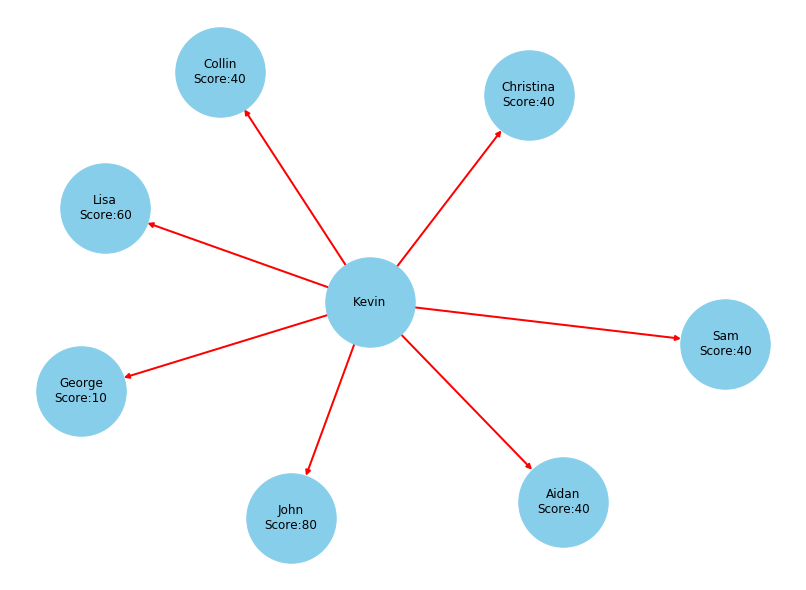

In [27]:
plotInfectionScoreGraph(proximityDF)